### San Diego Police Statistics and Analysis

There are plenty of observations that can be made using publicly available data from San Diego's open data portal. Traditionally, San Diego reports their crime data based on police reports that follow the Uniform Crime Reporting Program. These stats are displayed at https://crimestats.arjis.org/ and will give breakdowns of how many crimes were committed per agency for a given time period.

What this data doesn't show, however, are statistics relating to the original 911 call for service. How many times does a crime reported to 911 end up in an arrest? How many calls are cancelled due to lack of resources or information? 

These types of questions aren't easily answered simply by looking at reported crime statistics. Luckily, San Diego has made it easy to access and explore their police department calls for service, beats, and dispositions. The data can be found at https://data.sandiego.gov/datasets/
Lets begin by examining the data:

In [518]:
import pandas as pd
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import geopandas as gpd
import adjustText as aT
import folium

In [519]:
# Load in the San Diego Police 'calls for service' dataset for 2022
calls_for_service_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_calls_for_service_2022_datasd.csv')

# Load in supporting tables
#pd_dict_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_calls_for_service_dictionary_datasd.csv')
call_type_code_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_cfs_calltypes_datasd.csv')
disposition_code_df = pd.read_csv(r'http://seshat.datasd.org/pd/pd_dispo_codes_datasd.csv')
beat_code_df = pd.read_csv(r'https://seshat.datasd.org/pd/pd_beat_codes_list_datasd.csv')

# Map data:
beats_data_dict_df = pd.read_csv(r'https://seshat.datasd.org/sde/pd/pd_beats_dictionary_datasd.csv')
beats_topo_df = gpd.read_file(r'https://seshat.datasd.org/sde/pd/pd_beats_datasd.geojson')


### Preview subset of data

In [520]:
calls_for_service_df.head()

,incident_num,date_time,day_of_week,address_number_primary,address_dir_primary,address_road_primary,address_sfx_primary,address_dir_intersecting,address_road_intersecting,address_sfx_intersecting,call_type,disposition,beat,priority
0,E22010000001,2022-01-01 00:00:00,7,1300,NaN,MORAEA,ST,NaN,NaN,NaN,AU1,DUP,452,1
1,E22010000002,2022-01-01 00:00:07,7,600,NaN,BROADWAY,NaN,NaN,NaN,NaN,1186,CAN,524,3
2,E22010000003,2022-01-01 00:00:08,7,700,NaN,GRAND,AVE,NaN,NaN,NaN,1186,K,122,3
3,E22010000004,2022-01-01 00:00:15,7,4600,NaN,AIR,WAY,NaN,NaN,NaN,MPSSTP,K,447,2
4,E22010000005,2022-01-01 00:00:22,7,4700,NaN,MISSION BAY,DR,NaN,NaN,NaN,AU1,DUP,122,1


In [521]:
call_type_code_df.head()

,call_type,description,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,1016,PRISONER IN CUSTODY,NaN,NaN,NaN
1,1016PT,PTU (PRISONER TRANSPORT),NaN,NaN,NaN
2,1016QC,SHOPLIFTER/QUICK CITE,NaN,NaN,NaN
3,1021,PHONE YOUR STATION,NaN,NaN,NaN
4,1021H,PHONE YOUR HOME,NaN,NaN,NaN


In [522]:
disposition_code_df.head()

,dispo_code,description
0,X,DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ON...
1,A,ARREST MADE
2,AB,"ARREST MADE, BOARD AND SECURE"
3,AHR,"ARREST MADE, HIGH RISK (CRISIS RESPONSE TEAM)"
4,R,REPORT


In [523]:
beat_code_df.head()

,beat,neighborhood
0,111,Clairemont Mesa East
1,112,Clairemont Mesa West
2,113,Bay Ho
3,114,North Clairemont
4,115,University City


## Clean Data:

Notice here in that there are 3 columns without any label in the call type table. Let's check for values:

In [524]:
print(call_type_code_df['Unnamed: 2'].unique())
print(call_type_code_df['Unnamed: 3'].unique())
print(call_type_code_df['Unnamed: 4'].unique())

[nan]
[nan]
[nan 'U']


There are no non-null values for Unnamed 2 and Unnamed 3. Unnamed 4 is either null or 'U'.

In [525]:
call_code_df = call_type_code_df[call_type_code_df['Unnamed: 4'] == 'U']
call_code_df

,call_type,description,Unnamed: 2,Unnamed: 3,Unnamed: 4
204,CCF,CITIZEN'S COMPLAINT INVESTIGAT,NaN,NaN,U


This value corresponds to a call type of "CITIZEN'S COMPLAINT INVESTIGAT". This may denote an internal investigation. We'll leave that column in the table.

In [526]:
call_code_df = call_type_code_df[['call_type', 'description', 'Unnamed: 4']]
#call_code_df

Check for duplicates and records without any primary key (Incident number in this case)

In [527]:
## Check if any rows are missing a primary key value or date
calls_for_service_df['incident_num'].isnull().values.any() | calls_for_service_df['date_time'].isnull().values.any()

False

Number of non-null values for each column:

In [528]:
# Get initial counts of records in calls_for_service_df:
print(calls_for_service_df.count())

incident_num                 247348
date_time                    247348
day_of_week                  247348
address_number_primary       247348
address_dir_primary           11438
address_road_primary         247315
address_sfx_primary          225453
address_dir_intersecting          0
address_road_intersecting     42226
address_sfx_intersecting          0
call_type                    247023
disposition                  246166
beat                         247348
priority                     247348
dtype: int64


We can see in the above count that there are call records with no type (classified as 'NaN' or Null). Any records without a proper call type will possibly skew category percentages if they are taken out of total number of records. Similarly, records without a disposition or beat will also affect figures if those nulls are not excluded. The data is still useful, however, so we'll create a seperate dataframe to exclude those records for now:

In [529]:
# Remove any records with a null call_type, disposition, or beat
calls_df = calls_for_service_df.dropna(subset=['call_type', 'disposition', 'beat'])

# Drop any duplicate records while we're at it
calls_df.drop_duplicates()
print('Number of records excluded: ', len(calls_for_service_df) - len(calls_df))

Number of records excluded:  1506


There are a number of call types I'll chose to filter out. Namely, duplicate calls (with a disposition of DUP or V ) as well as certain 10-codes that aren't calls for service (10-21 phone your station, 10-21H phone your home, 10-22, disregard)

In [530]:
calls_df2 = calls_df[(calls_df.disposition != 'DUP') & (calls_df.disposition != 'V')]
print('Number of duplicate records filtered: ', len(calls_df) - len(calls_df2))

calls_df3 = calls_df2[(calls_df2.call_type != '1021') & (calls_df2.call_type != '1021H') & (calls_df2.call_type != '1022')]
print('Number of records filtered by call type: ', len(calls_df2) - len(calls_df3))

print('Percent of total records removed: ', (len(calls_df) - len(calls_df3))/len(calls_df)*100)

Number of duplicate records filtered:  4372
Number of records filtered by call type:  2327
Percent of total records removed:  2.724920884145101


Now is a good time to join the data definition tables to our main calls dataset. 

In [531]:
# Join calls with descriptions of calls on call code (Police 10 codes)
calls_df4 = pd.merge(calls_df3,
                    call_code_df,
                    left_on='call_type',
                    right_on='call_type',
                    how='left')

# Join calls with dispositions (outcomes) on disposition code
calls_df4_join = pd.merge(calls_df4,
                     disposition_code_df,
                     left_on='disposition',
                     right_on='dispo_code',
                     how='left',
                     suffixes=(None, '_disposition'))

# Join calls with beat locations on beat number
calls_df5 = pd.merge(calls_df4_join,
                    beat_code_df,
                    left_on='beat',
                    right_on='beat',
                    how='left')

This join leaves us with a dataframe containing the following columns:

In [532]:
calls_df5.columns

Index(['incident_num', 'date_time', 'day_of_week', 'address_number_primary',
       'address_dir_primary', 'address_road_primary', 'address_sfx_primary',
       'address_dir_intersecting', 'address_road_intersecting',
       'address_sfx_intersecting', 'call_type', 'disposition', 'beat',
       'priority', 'description', 'Unnamed: 4', 'dispo_code',
       'description_disposition', 'neighborhood'],
      dtype='object')

Each beat belongs to a division. The first digit of a beat indicates its division. Let's add the division to each call record to make things simpler.

In [533]:
districts = [[1, "Northern"], [2, "Northeastern"], [3, "Eastern"], [4, "Southeastern"], [5, "Central"], [6, "Western"], [7, "Southern"], [8, "Mid City"], [9, "Northwestern"]]
district_df = pd.DataFrame(districts, columns=['division_prefix', 'district'])
district_df

,division_prefix,district
0,1,Northern
1,2,Northeastern
2,3,Eastern
3,4,Southeastern
4,5,Central
5,6,Western
6,7,Southern
7,8,Mid City
8,9,Northwestern


Add a division column to each call record

In [534]:
calls_df5['division_prefix'] = calls_df5.apply(lambda row: row.beat/100, axis=1)
calls_df5['division_prefix'] = calls_df5['division_prefix'].astype(int)

calls_df5 = pd.merge(calls_df5,
                    district_df,
                    left_on='division_prefix',
                    right_on='division_prefix',
                    how='left')

calls_df5['district'].value_counts()

Central         55148
Western         37576
Northern        35788
Mid City        33618
Eastern         28029
Southeastern    23579
Southern        17282
Northeastern    16917
Northwestern    11146
Name: district, dtype: int64

Now to check out the geospacial dataset that indicates borders of each police beat:

In [535]:
#beats_topo_df.crs

In [536]:
beats_topo_df.head()

,objectid,beat,div,serv,name,geometry
0,3,935,9,930,NORTH CITY,"POLYGON ((-117.23876 32.98575, -117.23870 32.9..."
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((-117.22526 32.70267, -117.2252..."
2,8,511,5,510,None,"MULTIPOLYGON (((-117.22529 32.70260, -117.2252..."
3,9,722,7,720,NESTOR,"POLYGON ((-117.09042 32.58382, -117.09001 32.5..."
4,10,314,3,310,BIRDLAND,"POLYGON ((-117.15149 32.80650, -117.15140 32.8..."


In [537]:
print('Number of entries in beats_topo_df: ', len(beats_topo_df))
print('Number of unique entries in beats_topo_df: ', len(beats_topo_df['name'].unique()))

Number of entries in beats_topo_df:  140
Number of unique entries in beats_topo_df:  127


There are duplicate name/beat combinations within this table, since there are beats that are divided by another. To achieve a cleaner graph later on, we'll only keep one name label per beat

In [538]:
# Show records with duplicate beat/name entries and remove them
res = beats_topo_df[beats_topo_df.duplicated('name')]
beats_topo_df = beats_topo_df.drop_duplicates(subset=['name'])
res

,objectid,beat,div,serv,name,geometry
24,59,9,0,0,SAN DIEGO,"POLYGON ((-116.92564 32.61161, -116.92565 32.6..."
40,138,9,0,0,SAN DIEGO,"POLYGON ((-116.93104 32.64947, -116.93220 32.6..."
47,174,123,1,120,MISSION BAY,"POLYGON ((-117.21181 32.79891, -117.21142 32.7..."
55,206,123,1,120,MISSION BAY,"POLYGON ((-117.22077 32.79526, -117.22077 32.7..."
61,252,9,0,0,SAN DIEGO,"POLYGON ((-116.54563 32.68521, -116.54561 32.6..."
90,423,436,4,430,SKYLINE,"POLYGON ((-117.03725 32.71217, -117.03626 32.7..."
98,445,123,1,120,MISSION BAY,"POLYGON ((-117.23217 32.77811, -117.23235 32.7..."
114,510,711,7,710,TIJUANA RIVER VALLEY,"POLYGON ((-117.11885 32.54294, -117.11885 32.5..."
115,511,711,7,710,TIJUANA RIVER VALLEY,"POLYGON ((-117.11880 32.55086, -117.11880 32.5..."
116,512,711,7,710,TIJUANA RIVER VALLEY,"POLYGON ((-117.11879 32.55146, -117.11879 32.5..."


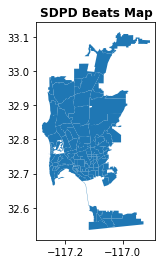

In [539]:
# plot beats geojson file
beats_topo_df.plot()
plt.title('SDPD Beats Map',fontweight='bold')
plt.savefig("BeatsMap.png")

## Analysis of data

#### Top 15 Categories of calls for service from SDPD

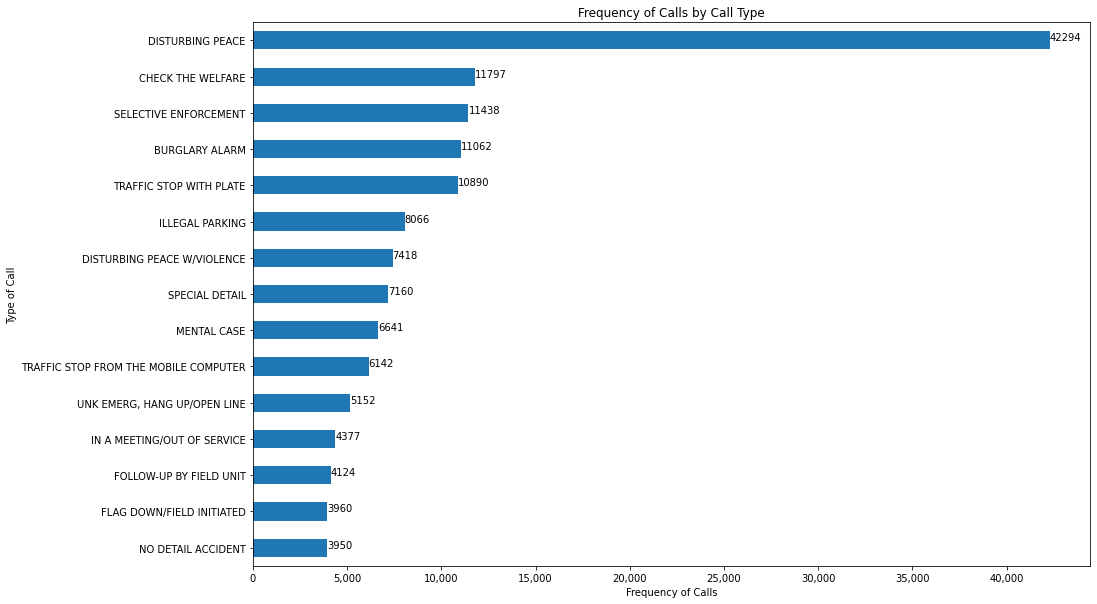

In [540]:
# Show the top 10 categories of calls for service
#calls_df5['description'].value_counts().head(15)

# Plot on graph
calls_df6 = calls_df5['description'].value_counts(ascending=True)

fig = plt.figure(figsize=(15, 10))
plt.title("Frequency of Calls by Call Type")
plt.xlabel("Frequency of Calls")
plt.ylabel("Type of Call")
ax = calls_df6.tail(15).plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
for index, value in enumerate(calls_df6.tail(15)):
    plt.text(value, index,
             str(value))
plt.savefig("TypeOfCall.png")

#### What usually happens once SDPD responds to the call?

In [541]:
calls_df5['description_disposition'].value_counts()

NO REPORT REQUIRED                                              144313
OTHER                                                            35854
REPORT                                                           23422
CANCEL                                                           22739
NO DISPATCH OR INCIDENT CANCLLED PRIOR TO DISPATCHING A UNIT     18261
ARREST MADE                                                      10348
UNFOUNDED                                                         6450
STOLEN VEHICLE OR RECOVERED VEHICLE                                504
DISPATCHED ALARM CALL CANCELLED BEFORE UNIT ONSCENE                485
NO FURTHER ACTION, HIGH RISK (CRISIS RESPONSE TEAM)                 15
OTHER, HIGH RISK (CRISIS RESPONSE TEAM)                             15
NO REPORT REQUIRED, BOARD AND SECURE                                13
ARREST MADE, BOARD AND SECURE                                        2
REPORT TAKEN, BOARD AND SECURE                                       2
REPORT

The following graph appears to confirm the stereotype about cops and paperwork:

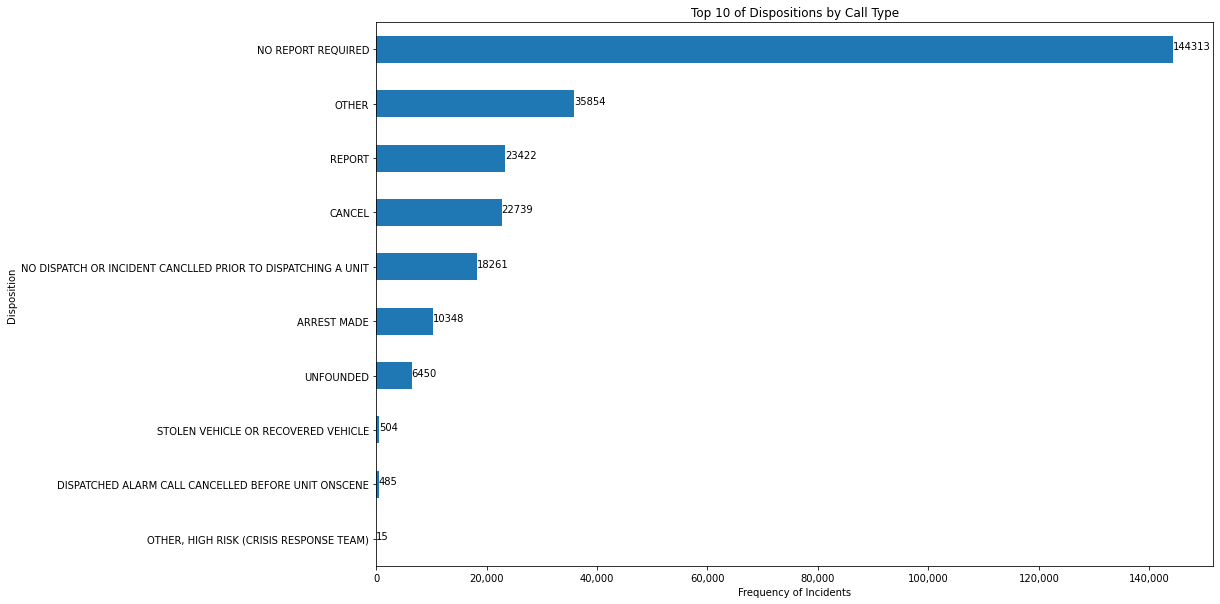

In [542]:
calls_dispo_outcome = calls_df5['description_disposition'].value_counts(ascending=True)
top_ten = calls_dispo_outcome.tail(10)
fig = plt.figure(figsize=(15, 10))
plt.title("Top 10 of Dispositions by Call Type")
plt.xlabel("Frequency of Incidents")
plt.ylabel("Disposition")
ax = top_ten.plot(kind='barh')
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
for index, value in enumerate(top_ten):
    plt.text(value, index,
             str(value))
plt.savefig("TypeOfDispo.png")

#### What percentage of incidents resulted in arrest?

In [543]:
calls_df_arrests = calls_df5[(calls_df5.description_disposition == 'ARREST MADE') | (calls_df5.description_disposition == 'ARREST MADE, BOARD AND SECURE')]
print("Number of arrests: ", len(calls_df_arrests))
print("Number of calls: ", len(calls_df5))
arrest_percent = len(calls_df_arrests)/len(calls_df5) * 100

Number of arrests:  10350
Number of calls:  262445


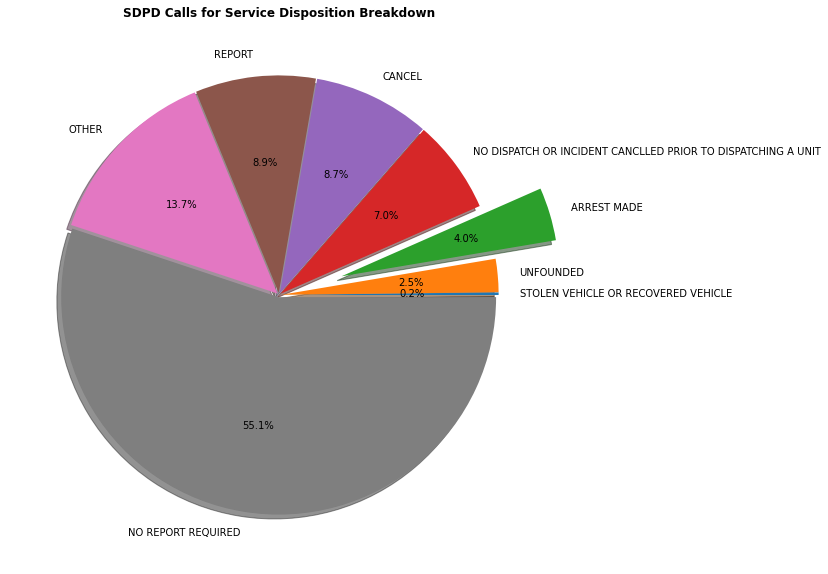

In [544]:
# Display percentage of arrests made
top_eight = calls_dispo_outcome.tail(8)

def convertToPercent(x):
        return x/len(calls_df5) * 100

labels = top_eight.axes[0]
sizes = top_eight.values

for i in sizes:
        i = convertToPercent(i)

plt.figure(figsize=(10,10))
explode = (0.01, 0.01, 0.3, 0.01, 0.01, 0.01, 0.01, 0.01)  # emphasize arrests

plt.pie(sizes, explode=explode, labels=labels, shadow=True, autopct='%.1f%%')
plt.title('SDPD Calls for Service Disposition Breakdown',fontweight='bold')

plt.savefig("DispoPieChart.png")

#### How many of those calls were citizen's complaints?

In [545]:
calls_complaints_df = calls_df5[calls_df5.description == 'CITIZEN\'S COMPLAINT INVESTIGAT']
print('Complaints against officers: ', len(calls_complaints_df))
print('Percent of calls:', len(calls_complaints_df)/len(calls_df5) * 100)

Complaints against officers:  152
Percent of calls: 0.05791689687363067


##### How many calls for service were made by each neighborhood/beat?

In [546]:
# This graph was used for intial analysis, but has overlapping labels. It runs much faster than the text adjusted graph, so I'll leave it here
# beats_topo_df['coords'] = beats_topo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
# beats_topo_df['coords'] = [coords[0] for coords in beats_topo_df['coords']]
# fig, ax = plt.subplots(figsize = (30,30))
# ax.set_axis_off()
# beats_topo_df.plot(ax=ax, color='yellow', edgecolor='white')
# for idx, row in beats_topo_df.iterrows():
#     plt.annotate(text=row['name'], xy=row['coords'], horizontalalignment='center', color='black')

In the original shapefiles we have polygons which describe the shape of each beat. To place a label on each beat, we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

34

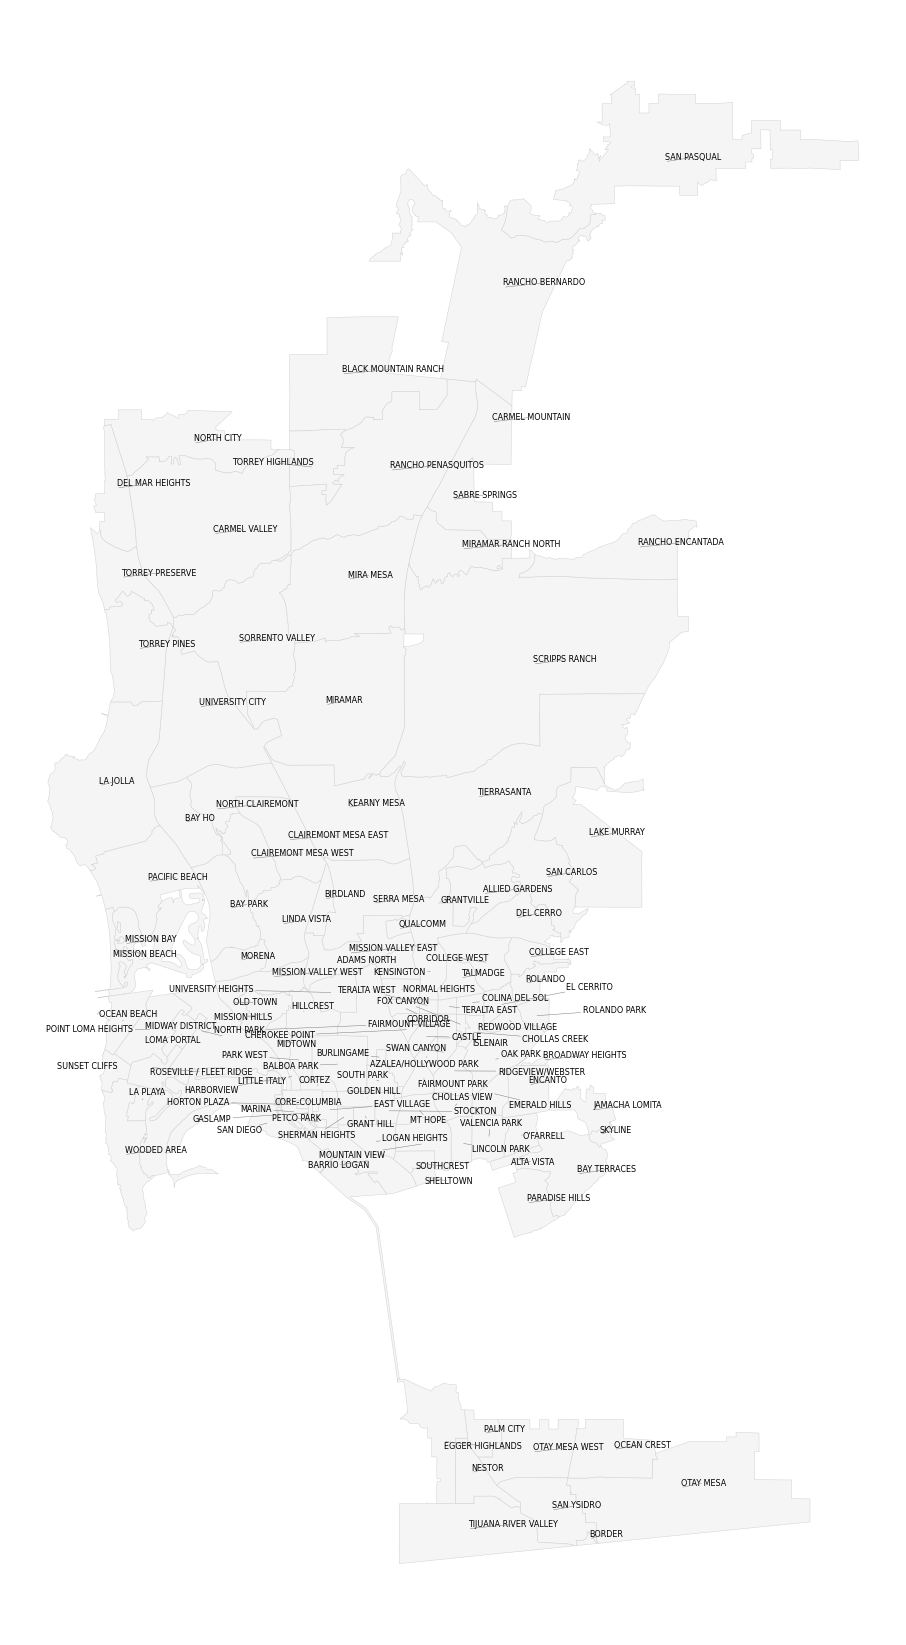

In [547]:
# Here we find the representative points, copy our original df to a new df. We could alternatively use centroid, however this graph is going to be very tight
beats_topo_df['representative'] = beats_topo_df['geometry'].representative_point()
beats_topo_df_points = beats_topo_df.copy()

# and then set the geometry column to the newly created representative points column (because a GeoPandas df can only have one geometry column)
beats_topo_df_points.set_geometry('representative', inplace= True)
ax = beats_topo_df.plot(figsize = (30, 30), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
ax.set_axis_off()
texts = []

# label each region according to the name
for x, y, label in zip(beats_topo_df_points.geometry.x, beats_topo_df_points.geometry.y, beats_topo_df_points["name"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

# adjustText shuffles the region label annotations and uses arrows when neccessary to prevent them from obscuring another
# Note, this is a very expensive operation
aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

This is fine and dandy, but an interactive map would be easier to navigate

In [548]:
calls_df5['neighborhood'].value_counts()

East Village            12867
Pacific Beach            9410
Core-Columbia            8820
North Park               7016
Midway District          6801
                        ...  
Qualcomm                   96
Islenair                   86
Tijuana River Valley       75
Burlingame                 68
Broadway Heights           64
Name: neighborhood, Length: 125, dtype: int64

In [549]:
# def plot(df, col):
#     fig = plt.figure(figsize = (30, 30))
#     ax = fig.add_subplot(111)
#     ax.set_axis_off()
    
#     # Utilize fisher-jenks algorithm to bin data based on natural breaks
#     df.plot(ax=ax,column=col, cmap='YlOrRd',scheme='fisher_jenks', legend=True)
#     # for idx, row in beats_topo_df_points.iterrows():
#     #     plt.annotate(text=row['beat'], xy=row['geometry'], horizontalalignment='center', color='blue')
#     plt.title('Heatmap of calls for service by beat',fontweight='bold')

# plot(gpd.GeoDataFrame(beats_topo_df_points.groupby('beat').incident_num.count().to_frame().join(beats_topo_df_points)), 'incident_num')


In [550]:
# Map of neighborhood beats
#Image(filename='datasets/neighborhoods.png', width=900) 

#### Create interactive map using Folium to plot polygons

In [552]:
# Create interactive map using Folium to plot polygons
# beats_topo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [561]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
#df = beats_topo_df.to_crs(epsg=4326)
print(beats_topo_df.crs)
beats_topo_df.head()

epsg:4326


,objectid,beat,div,serv,name,geometry,representative
0,3,935,9,930,NORTH CITY,"POLYGON ((-117.23876 32.98575, -117.23870 32.9...",POINT (-117.21436 32.97266)
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((-117.22526 32.70267, -117.2252...",POINT (-117.17948 32.70714)
2,8,511,5,510,None,"MULTIPOLYGON (((-117.22529 32.70260, -117.2252...",POINT (-117.22143 32.68612)
3,9,722,7,720,NESTOR,"POLYGON ((-117.09042 32.58382, -117.09001 32.5...",POINT (-117.08516 32.57040)
4,10,314,3,310,BIRDLAND,"POLYGON ((-117.15149 32.80650, -117.15140 32.8...",POINT (-117.15372 32.79448)


In [571]:
m = folium.Map(location=[32.7157, -117.1611], zoom_start=10, tiles='CartoDB positron') # also looks good with OpenStreetMap tiles

for _, r, in beats_topo_df.iterrows():
    # Without simplifying the representation of each beat, the map will not display
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In order to properly compute geometric properties, in this case centroids, of the geometries, we need to project the data to a projected coordinate system.

In [563]:
# Project to NAD83 projected crs
beats_topo_df_centroid = beats_topo_df.to_crs(epsg=2263)

# Access the centroid attribute of each polygon
beats_topo_df_centroid['centroid'] = beats_topo_df_centroid.centroid

# Project to WGS84 geographic crs
# geometry (active) column
beats_topo_df_centroid = beats_topo_df_centroid.to_crs(epsg=4326)

# Centroid column
beats_topo_df_centroid['centroid'] = beats_topo_df_centroid['centroid'].to_crs(epsg=4326)

beats_topo_df_centroid.head()

,objectid,beat,div,serv,name,geometry,representative,centroid
0,3,935,9,930,NORTH CITY,"POLYGON ((-117.23876 32.98575, -117.23870 32.9...",POINT (-117.21436 32.97266),POINT (-117.21924 32.97367)
1,7,0,0,0,SAN DIEGO,"MULTIPOLYGON (((-117.22526 32.70267, -117.2252...",POINT (-117.17948 32.70714),POINT (-117.18884 32.70407)
2,8,511,5,510,None,"MULTIPOLYGON (((-117.22529 32.70260, -117.2252...",POINT (-117.22143 32.68612),POINT (-117.21583 32.70159)
3,9,722,7,720,NESTOR,"POLYGON ((-117.09042 32.58382, -117.09001 32.5...",POINT (-117.08516 32.57040),POINT (-117.08349 32.56824)
4,10,314,3,310,BIRDLAND,"POLYGON ((-117.15149 32.80650, -117.15140 32.8...",POINT (-117.15372 32.79448),POINT (-117.15478 32.79197)


In [560]:
for _, r in beats_topo_df_centroid.iterrows():
    lat = r['centroid'].y
    lon = r['centroid'].x
    folium.Marker(location=[lat, lon],
                  popup='Neighborhood: {} <br> Beat: {}'.format(r['name'], r['beat'])).add_to(m)
m

In [572]:
folium.Choropleth(
    geo_data=beats_topo_df_centroid,
    name="choropleth map",
    data=calls_df5,
    columns=["neighborhood", "incident_num"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Calls",
).add_to(m)

folium.LayerControl().add_to(m)

m

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
calls_df6.to_csv('out.csv')